# Transformer encoder pretraining

In [270]:
import os
import sys
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch

sys.path.append('../../modules/')

from logger_tree_language import get_logger
from models import TransformerClassifier
from masked_language_modeling import train_model_mlm, mask_sequences
from plotting import plot_training_history
from pytorch_utilities import create_linear_lr_schedulers, lr_linear_update

logger = get_logger('transformer_encoder_pretraining')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_PATH = '../../data/mlm_data/slrm_data/labeled_data_fixed_4_8_1.0_0.00000.npy'

Load data

In [3]:
q, k, sigmas, epsilons, roots_seeds, leaves_seeds, rho_seeds = np.load(DATA_PATH, allow_pickle=True)

# The last index corresponds to the seed that generated the
# data/transition tensors: select one.
seed = 0

shuffled_indices = np.random.choice(range(leaves_seeds.shape[1]), leaves_seeds.shape[1], replace=False)

roots = roots_seeds[:, seed]
roots = roots[shuffled_indices]

leaves = leaves_seeds[..., seed].T
leaves = leaves[shuffled_indices, :]
rho = rho_seeds[..., seed]

Drop the duplicated sequences.

**Note:** this is **a possible choice**, not necessarily the best one - we might choose to keep some or all of the repetitions.

In [4]:
leaves_df = pd.DataFrame(leaves, columns=[f's_{i}' for i in range(leaves.shape[1])])

print(
    'Fraction of repeated sequences:',
    leaves_df.duplicated(keep=False).sum() / leaves.shape[0]
)

unique_indices = leaves_df[~leaves_df.duplicated(keep=False)].index.tolist()

print('Remaining unique sequences:', len(unique_indices), f'(of {leaves.shape[0]})')

leaves = leaves[unique_indices, :]

leaves.shape

Fraction of repeated sequences: 0.0
Remaining unique sequences: 50000 (of 50000)


(50000, 256)

Generate a vocabulary.

In [5]:
vocab = torch.arange(q).to(dtype=torch.int64)
mask_idx = vocab.max() + 1

# Enalarge the vocabulary with the special tokens.
vocab = torch.hstack([vocab, torch.Tensor(mask_idx).to(dtype=torch.int64)])

vocab

tensor([0, 1, 2, 3, 4])

Data preprocessing.

In [6]:
leaves = torch.from_numpy(leaves).to(device=device).to(dtype=torch.int64)

Define model.

In [271]:
seq_len = int(2 ** k)
embedding_size = 128
vocab_size = vocab.shape[0]

# Instantiate model.
model_params = dict(
    seq_len=seq_len,
    embedding_size=embedding_size,
    n_tranformer_layers=2,  # Good: 4
    n_heads=1,
    vocab_size=vocab_size,
    encoder_dim_feedforward=2 * embedding_size,
    positional_encoding=True,
    n_special_tokens=1,  # We assume the special tokens correspond to the last `n_special_tokens` indices.
    embedding_agg=None,
    decoder_hidden_sizes=[64],  # Good: [64]
    decoder_activation='relu',  # Good: 'relu'
    decoder_output_activation='identity'
)

model = TransformerClassifier(
    **model_params
).to(device=device)

# Instantiate optimizer.
optimizer_params = dict(
    lr=1e-4,
    betas=(0.9, 0.999),
    eps=1e-08,  # 1e-6 for BERT.
    weight_decay=0  # 0.01 for BERT.
)

optimizer = torch.optim.Adam(
    params=model.parameters(),
    **optimizer_params
)

# Create a directory in which to save the train model (and checkpoints) and the
# optimizer's final state.
model_dir = '../../models/test_model_lr_scheduling/'

if model_dir is not None:
    # Create model directory if it doesn't exist.
    if not os.path.exists(model_dir):
        logger.info(f'Creating model directory: {model_dir}')

        os.makedirs(model_dir)

    # Save model's and optimizer's (hyper)parameters.
    model_params_path = os.path.join(model_dir, 'model_params.json')

    with open(model_params_path, 'w') as f:
        json.dump(model_params, f)
    
    optimizer_params_path = os.path.join(model_dir, 'optimizer_params.json')

    with open(optimizer_params_path, 'w') as f:
        json.dump(optimizer_params, f)

# Set up learning rate scheduling.
batch_size = 32  # 32 is the standard (e.g. in Keras)
n_epochs = 10
warmup_updates_frac = 0.15

n_updates_total = int(leaves.shape[0] / batch_size) * n_epochs
n_updates_warmup = int(n_updates_total * warmup_updates_frac)
n_updates_decay = n_updates_total - n_updates_warmup

lr_scheduler_warmup, lr_scheduler_decay = create_linear_lr_schedulers(optimizer, n_updates_warmup, n_updates_decay)
lr_schedule_fn = lambda update_counter: lr_linear_update(update_counter, lr_scheduler_warmup, lr_scheduler_decay, n_updates_warmup)

/home/moscato/miniconda3/envs/tree-language/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-04-29 19:22:15,771 - transformer_encoder_pretraining - INFO - Creating model directory: ../../models/test_model_lr_scheduling/


2024-04-29 19:22:22,451 - transformer_encoder_pretraining - INFO - Training model
100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:57<00:00, 11.72s/it, learning_rate=1e-6, training_accuracy=tensor(0.4661), training_loss=tensor(1.2224)]
2024-04-29 19:24:19,690 - transformer_encoder_pretraining - INFO - Last epoch: 10
2024-04-29 19:24:19,690 - transformer_encoder_pretraining - INFO - Saving final model checkpoint


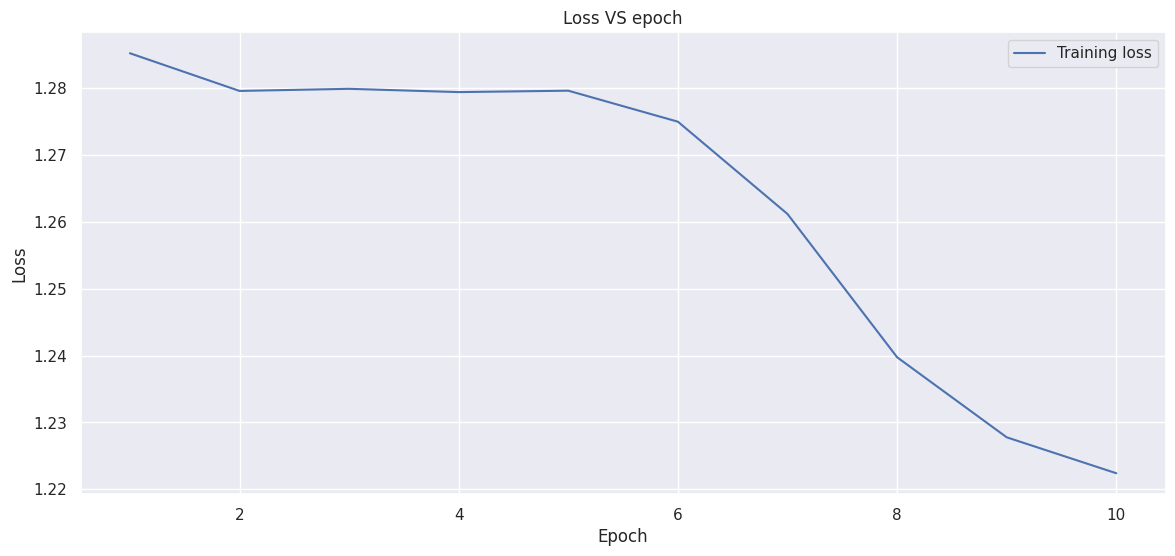

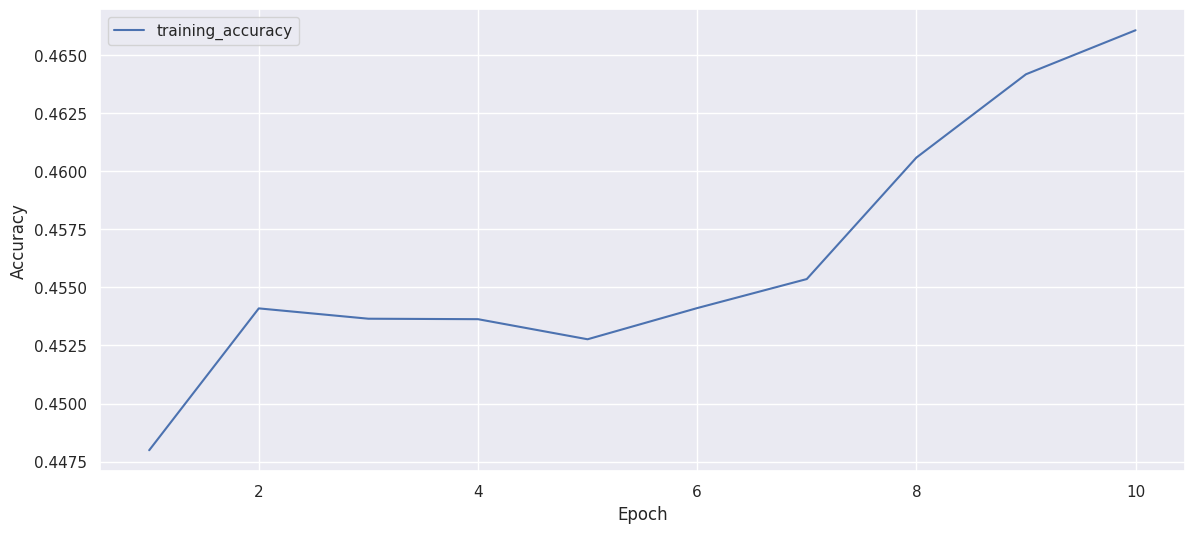

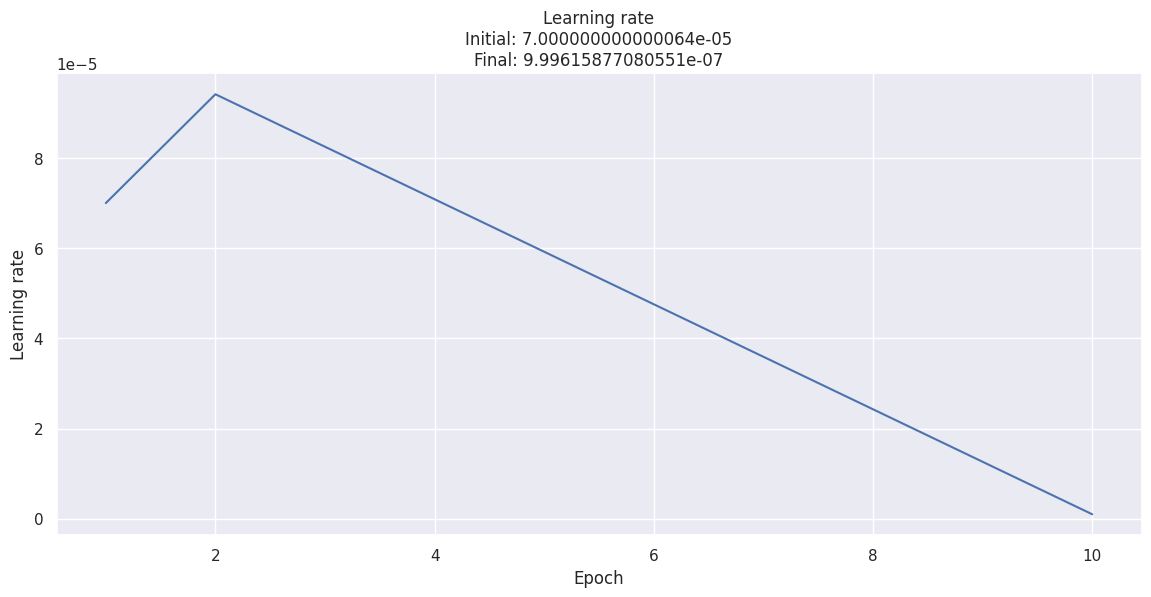

In [272]:
model, optimizer, training_history = train_model_mlm(
    sequences=leaves,
    model=model,
    n_epochs=n_epochs,
    batch_size=batch_size,
    mask_rate=0.1,
    mask_idx=mask_idx,
    device=device,
    optimizer=optimizer,
    lr_schedule_fn=lr_schedule_fn,
    checkpointing_period_epochs=5,
    model_dir=model_dir,
    checkpoint_id='test_model_lr_scheduling'
)

plot_training_history(training_history)#, savefig_dir='../../data/mlm_data/', exp_id='n_transformer_layers_2')

In [307]:
# To check and set training/evaluation mode in the model
# (`torch.nn.module` object) - this is needed to deactivate
# dropout at inference time.
# model.training
# model.train(mode=True)

# with torch.no_grad():
#     pred = torch.argmax(model(leaves[:32]), dim=-1)

# (pred == leaves[:32]).to(dtype=torch.float32).mean().detach()

## Test saving/loading model and optimizer, and resuming training

In [275]:
from pytorch_utilities import optimizer_to, load_checkpoint

Save checkpoint.

In [276]:
# checkpoint_path = '../../models/test_model.pt'

# torch.save(
#     {
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'training_history': training_history
#     },
#     checkpoint_path
# )

Load checkpoint.

In [277]:
model_loaded, optimizer_loaded, training_history_loaded = load_checkpoint(
    model_dir,
    'test_model_lr_scheduling_epoch_10.pt',
    device=device
)

/home/moscato/miniconda3/envs/tree-language/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


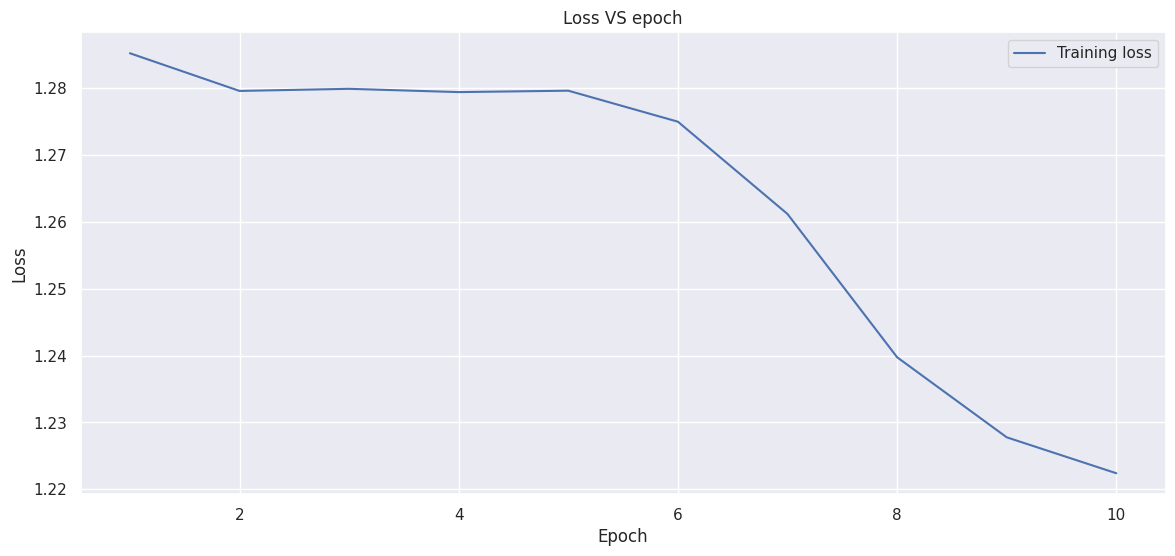

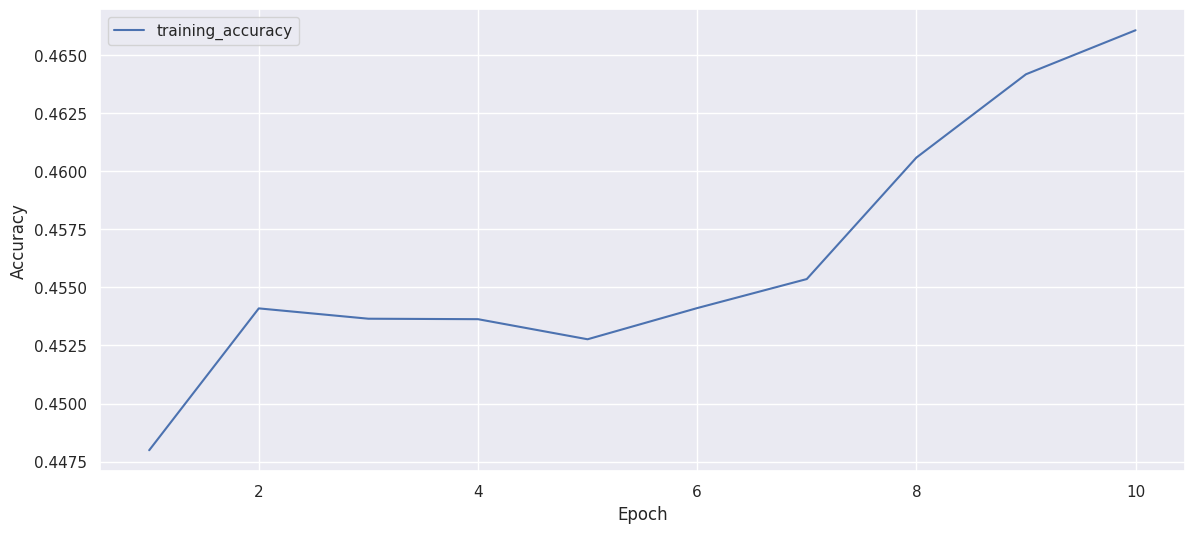

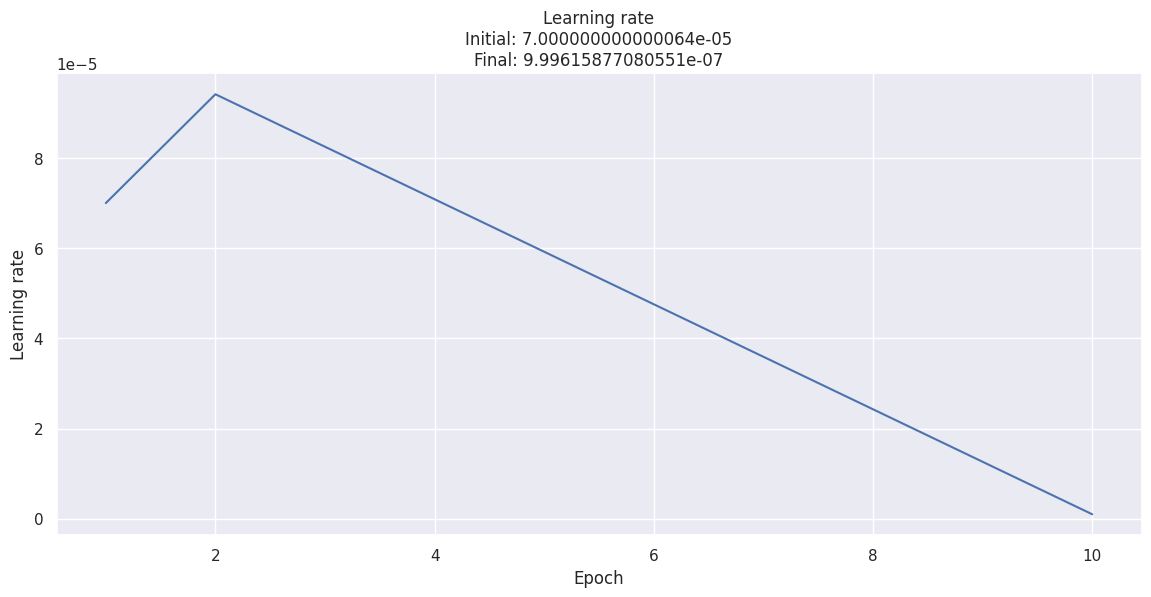

In [278]:
plot_training_history(training_history_loaded)

Resume training.

2024-04-29 19:25:58,316 - transformer_encoder_pretraining - INFO - Training model
2024-04-29 19:25:58,316 - transformer_encoder_pretraining - INFO - Resuming training from epoch 10
100%|█████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:25<00:00, 12.66s/it, learning_rate=1e-6, training_accuracy=tensor(0.4670), training_loss=tensor(1.2217)]
2024-04-29 19:26:23,753 - transformer_encoder_pretraining - INFO - Last epoch: 12


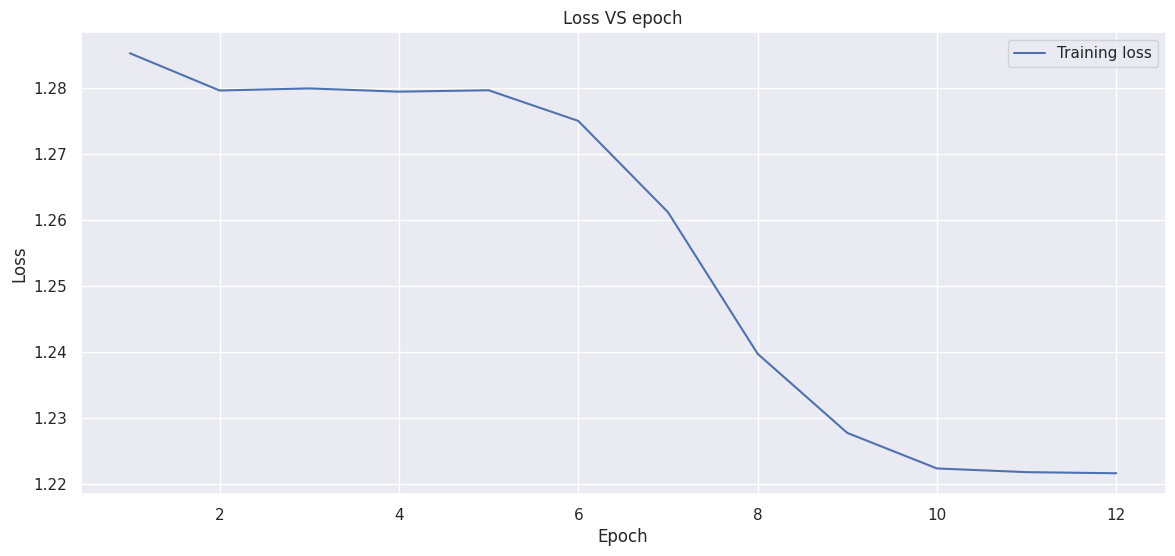

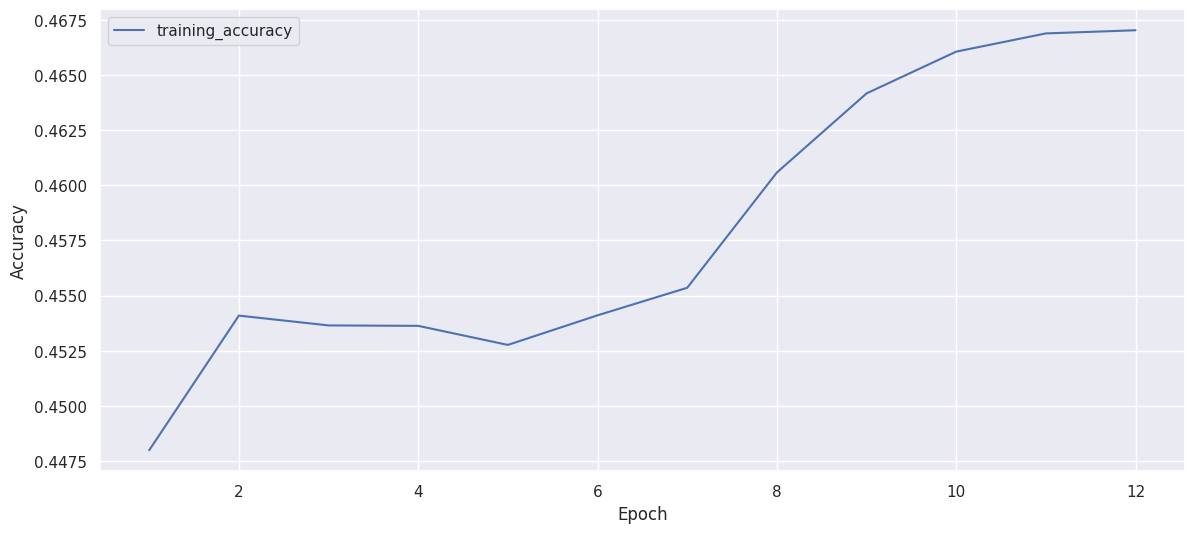

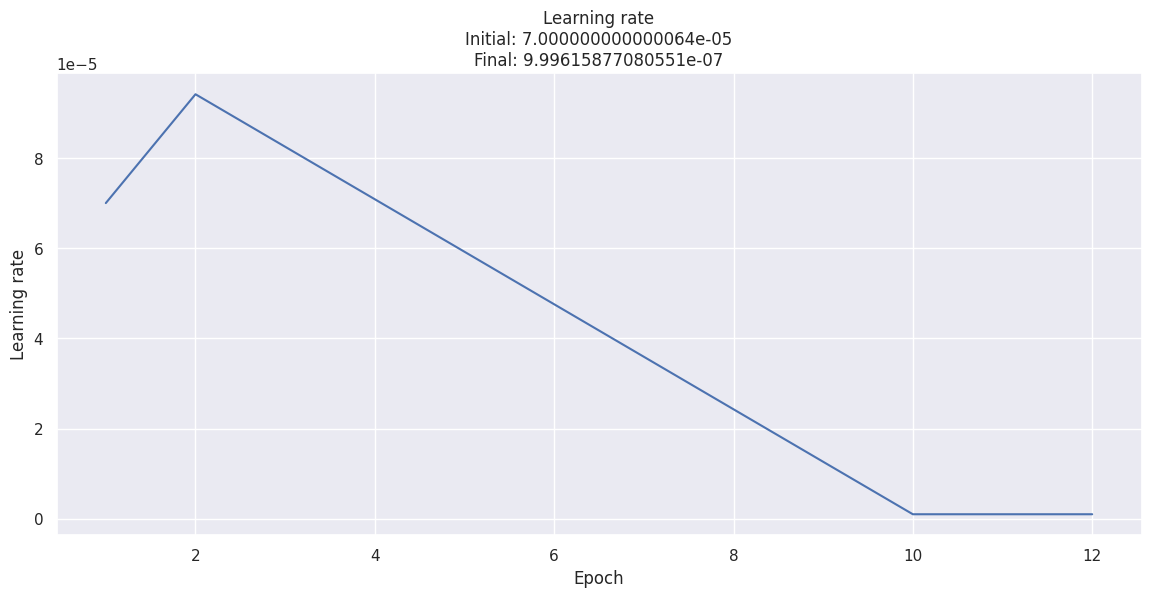

In [281]:
model_loaded, optimizer_loaded, training_history_loaded = train_model_mlm(
    sequences=leaves,
    model=model_loaded,
    n_epochs=2,
    batch_size=32,
    mask_rate=0.1,
    mask_idx=mask_idx,
    device=device,
    optimizer=optimizer_loaded,
    training_history=training_history_loaded
)

plot_training_history(training_history_loaded)